In [1]:
import logging

import matplotlib.pyplot as plt
import numpy as np

import regpy as rp
import regpy.operators.mri as rpm
from regpy.solvers.irgnm import IrgnmCG

import cfl
from regpy_bart import BartNoir

%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 6]

logging.basicConfig(
    level=logging.WARNING,
    format='%(asctime)s %(levelname)s %(name)-40s :: %(message)s'
)

def plotreco(reco, ref):
    fig, axes = plt.subplots(ncols=3)

    axes[0].set_title('reference solution')
    r = axes[0].imshow(np.fliplr(np.abs(ref).T), origin='lower')
    r.set_clim((0, r.get_clim()[1]))

    axes[1].set_title('reconstruction')
    im = axes[1].imshow(np.fliplr(np.abs(reco).T), origin='lower')
    im.set_clim(r.get_clim())

    axes[2].set_title('difference * 10')
    diff = axes[2].imshow(np.fliplr((np.abs(ref) - np.abs(reco)).T), origin='lower')
    diff.set_clim((0, r.get_clim()[1]/10.))

    plt.show()

In [2]:
datafile = 'data/unders_2_v8'
data = np.ascontiguousarray(cfl.readcfl(datafile).T).squeeze()

ncoils, nx, ny = data.shape
pattern = rpm.estimate_sampling_pattern(data)
data = data[:, pattern].flatten()

grid = rp.discrs.UniformGrid((-1, 1, nx), (-1, 1, ny), dtype=np.complex64)
bartop = BartNoir(grid, ncoils, pattern)

setting = rp.solvers.HilbertSpaceSetting(op=bartop, Hdomain=rp.hilbert.L2, Hcodomain=rp.hilbert.L2)

init = bartop.domain.zeros()
init_density, init_coils = bartop.domain.split(init)
init_density[...] = 1

reco, reco_data = IrgnmCG(
    setting, data=data / setting.Hcodomain.norm(data) * 100,
    init=init,
    regpar=1, regpar_step=1/2, cgstop=5
).run(
    rp.stoprules.CountIterations(max_iterations=11)
)
reco_postproc = rpm.normalize(*bartop.domain.split(bartop._forward_coils(reco)))

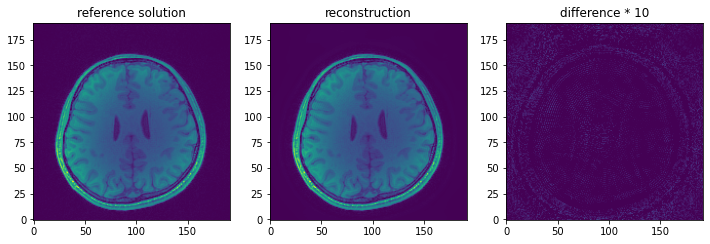

In [3]:
bart_reference = cfl.readcfl(datafile + '_bartref').T.squeeze()
plotreco(reco_postproc, bart_reference)